<a href="https://colab.research.google.com/github/stenoe/FEDS/blob/main/notebooks/class_notebooks/course2025_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps towards machine learning

Use "requests" library to load data into the colab virtual machine directly from internet/github...

To do so we need to:

1.   Set a path to a folder in the virtual machine
2.   Create it if it's not existing
3.   Open a file in that folder to write the data into (name of your choice!)
4.   Request data via a REST API with ```get()``` and write them to the file.

This is a code snippet you can reuse to load data into the virtual machine where your Colab Notebook is.

In [ ]:
import requests
from pathlib import Path

# setup path to data folder
data_path = Path('data/')

# If the data folder doesn't exist we create it
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping creation")
else:
  data_path.mkdir(parents=True, exist_ok=True)
  print(f"{data_path} does not exists, creating it...")

  # Download temperature anomaly data
  with open(data_path / "land_global_temperature_anomaly-1850-2003.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/stenoe/FEDS/refs/heads/main/data/land_global_temperature_anomaly-1850-2023.csv")
    print("Downloading data...")
    f.write(request.content)
    print("-- done!")



data directory already exists... skipping creation


## Let's show the data we did download

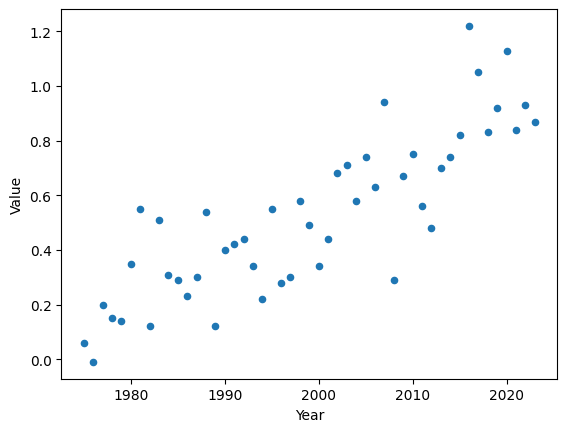

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(data_path / "land_global_temperature_anomaly-1850-2003.csv", skiprows = 4)
dfn = df[df.Year >= 1975]
dfn.plot.scatter("Year","Value");

## Prepare a simple linear regression

We want tot obtain a trend for our "unknown" data

To do so, let's use the np.polyfit() function

We calculate $f(x) = mx + b$


In [ ]:
reg = np.polyfit(dfn.Year, dfn.Value, 1)
print(reg)
print(f"f(x) = {reg[0]}x + {reg[1]}")

[ 1.73520408e-02 -3.41614235e+01]
f(x) = 0.017352040816326502x + -34.16142346938769


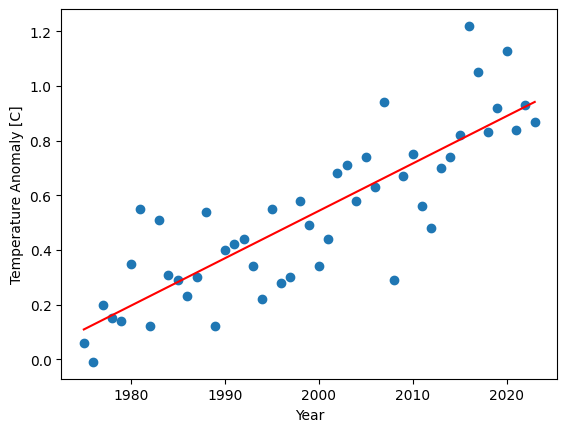

In [ ]:
# create the trendline
trend = np.polyval(reg, dfn.Year)
plt.scatter(dfn.Year, dfn.Value)
plt.plot(dfn.Year, trend, color='red')
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly [C]")
plt.show()

## Gradient decent introduction

We have the linear function:

$y = wx + b$

We don't know the parameters w and b! We want to learn them from the data. We need to create a "loss function" on which we can minimise the error:

$l = \frac{1}{N}\sum_{i=1}^{N}(y_i - (wx_i + b))^2$

## Gradient decent

We need to differentiate the above equation for w and b!

$\frac{\partial l}{\partial w} = \frac{1}{N}\sum_{i=1}^{N}-2x_i(y_i - (wx_i + b))$

$\frac{\partial l}{\partial b} = \frac{1}{N}\sum_{i=1}^{N}-2(y_i - (wx_i + b))$

Now that we have the gradients, let's update our parameters with them:

$w \leftarrow w - \alpha \frac{\partial l}{\partial w}$

$b \leftarrow b - \alpha \frac{\partial l}{\partial b}$

$\alpha$ is a hyperparameter for the algorithm, and it is aka learning rate.


Let's implement that into a python function:

In [ ]:
def update_w_and_b(years, values, w, b, alpha):
  dl_dw = 0.0
  dl_db = 0.0
  N = len(years)

  for i in range(N):
    dl_dw += -2 * years[i] * (values[i] - (w * years[i] + b))
    dl_db += -2 * (values[i] - (w * years[i] + b))

  # update w and b
  w = w - (1/float(N)) * dl_dw * alpha
  b = b - (1/float(N)) * dl_db * alpha

  return w, b

## Build a training function

The training function loops over the number of given epochs and takes care to update each time the values of the gradient $w$ and $b$ in our case.

In [ ]:
def train(years, values, w, b, alpha, epochs):
  for e in range(epochs):
    w, b = update_w_and_b(years, values, w, b, alpha)

    # log every 400th step so we can see this thing is working
    if e % 400 == 0:
      print(f"epoch: {e}, loss: {avg_loss(years, values, w, b)}, w: {w}, b: {b}")

  return w, b


## Build a loss function

To have a decision criteria if the gradient decent is learning we want to minimise the loss in every step, the algorithm can use this function's return value to stop execution if the desired accuracy is reached.

In [ ]:
def avg_loss(years, values, w, b):
  N = len(years)
  total_error = 0.0

  for i in range(N):
    total_error += (values[i] - (w * years[i] + b)) ** 2

  return total_error # / float(N)

## Building a prediction function

The prediction function takes the actual $w$ and $b$ parameters and returns a $y$ for it.

In [ ]:
def predict(x, w, b):
  return w*x + b

## Run the gradient decent and make a prediction with the learned parameters

In [ ]:
# run the gradient decent
#
# We initialise alpha = 0.001, w = 0.0, b = 0.0 , runn 15k epochs

w, b = train((dfn.Year-1975).to_list(),
             dfn.Value.to_list(),
             0.0, 0.0, 0.001, 15000)
x_new = 27.
y_new = predict(x_new, w, b)
print(f"\nPrediction for {x_new} is {y_new}")

epoch: 0, loss: 6.3524963618285755, w: 0.03215551020408164, b: 0.0010506122448979591
epoch: 400, loss: 1.3017512725111478, w: 0.020075253869057785, b: 0.02083580365647573
epoch: 800, loss: 1.268705872683487, w: 0.019568189645940707, b: 0.03722544013194228
epoch: 1200, loss: 1.24682091976631, w: 0.0191555411447619, b: 0.0505633145433762
epoch: 1600, loss: 1.2323271879099889, w: 0.01881972809039501, b: 0.06141766717538721
epoch: 2000, loss: 1.222728434651623, w: 0.018546443667548273, b: 0.0702509315641301
epoch: 2400, loss: 1.2163714753102775, w: 0.01832404500019607, b: 0.07743943578973643
epoch: 2800, loss: 1.21216145646931, w: 0.01814305712417732, b: 0.08328943537396899
epoch: 3200, loss: 1.209373290352528, w: 0.017995769320451854, b: 0.08805016084083526
epoch: 3600, loss: 1.2075267736055908, w: 0.017875906611393808, b: 0.09192443581206011
epoch: 4000, loss: 1.2063038823021632, w: 0.017778362424710734, b: 0.09507731800556778
epoch: 4400, loss: 1.2054939989677835, w: 0.01769898103553277

## Predict multiple values from the model

We can use the numpy ``linspace()`` function to generate a  set of data


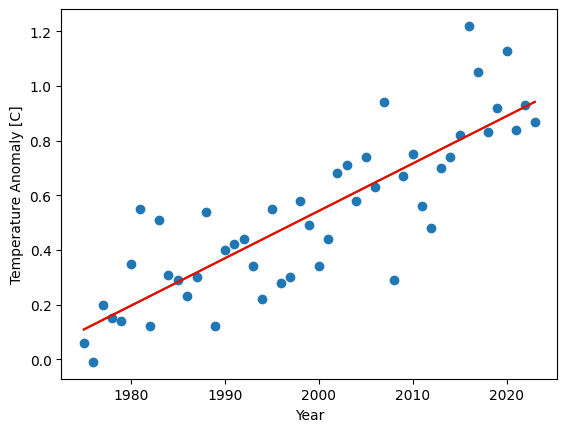

In [ ]:
xn = np.linspace(0, 2023-1975, 100)
yn = predict(xn, w, b)


plt.scatter(dfn.Year, dfn.Value)
plt.plot(dfn.Year, trend, color='green')
plt.plot(xn+1975, yn, color='red')
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly [C]")
plt.show()

## Use  scikit learn builtin ML algorithm

We can use the stochastic gradient decent algorithm.

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset and reshape it to fot the needs of the algorithm
X, y = np.array(dfn.Year-1975).reshape(-1, 1), np.array(dfn.Value)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Create and train the model
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.001)

# Fit or train the model
sgd_reg.fit(X_train, y_train)

# make predictions
y_pred = sgd_reg.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.0245851527309511


## The quality isn't that great, let's see why

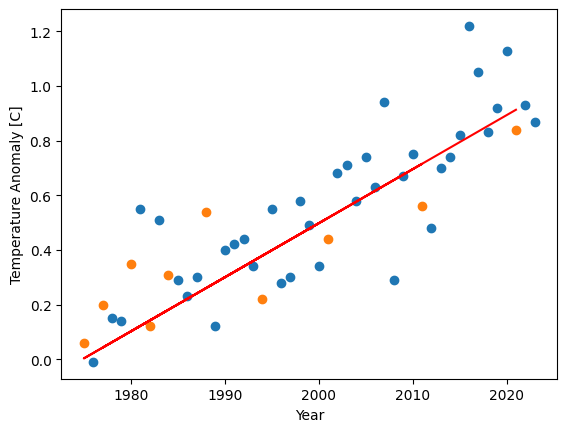

In [ ]:
plt.scatter(X_train+1975, y_train)
plt.scatter(X_test+1975, y_test)
plt.plot(X_test+1975, y_pred, color='red')
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly [C]")
plt.show()
